Generating and Testing the Fried Infinite Phase Screens
============================================

This notebook shows examples of using `aotools` to do the following:
- Create a simple phase screen with atmospheric statistics
- Extract and visualise the wavefront on the phase screen
- Move a phasescreen with wind (assuming frozen flow)
- Batch statistics of phase screens (Zernike breakdown)

In [25]:
import numpy
import matplotlib.pylab as plt
from tqdm import tqdm, trange, tqdm_notebook
from astropy.io import fits
%matplotlib inline

import aotools
from aotools.turbulence import infinitephasescreen
from matplotlib import animation, rc
from IPython.display import HTML

Creating a Phase Screen
-----------------------------

In [26]:
# Set up parameters for creating phase screens

nx_size = 64
D = 1.
pxl_scale = D/nx_size
r0 = 0.32
L0 = 100
wind_speed = 10 #m/s - just arbitrarily set
stencil_length_factor = 32

In [28]:
# Create the phase screen object using aotools
phase_screen = infinitephasescreen.PhaseScreenKolmogorov(nx_size, pxl_scale, r0, L0, stencil_length_factor=stencil_length_factor)

Now that we have created a phase screen object we can begin to experiment with it.

Seeing the Phase Screen
-----------------------------

One of the most useful things to do is to extract the phase of the wavefront of the phase screen in radians. This can be extracted simply using the `.scrn` attribute of the phase screen object. For example, to visualise the wavefront using matplotlib:

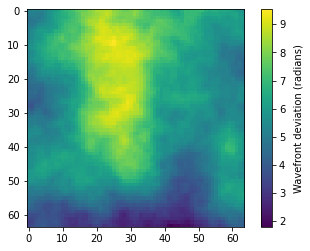

In [30]:
wavefront = phase_screen.scrn

plt.figure()
plt.imshow(wavefront)
cbar = plt.colorbar()
cbar.set_label('Wavefront deviation (radians)', labelpad=8)

Evolving a Phase Screen
-----------------------------

As we are using an infinite phase screen we can extrude it along an axis in order to simulate the effect of wind. This is efficient with memory, as the full path of a pupil over a phase screen does not need to be created and stored initially, with new phase being created and old phase lost over timesteps.

In [31]:
phase_screen.add_row()

array([[5.37793318, 5.50566491, 5.38356637, ..., 5.96479063, 5.69167394,
        5.48065315],
       [5.24405766, 5.29434303, 5.33544642, ..., 6.00149304, 5.8753662 ,
        5.72361494],
       [5.01714236, 5.13720942, 5.1511555 , ..., 6.3624472 , 6.00481974,
        5.85245035],
       ...,
       [3.69165381, 3.65220608, 3.62723601, ..., 4.67626869, 4.65481447,
        4.77200796],
       [3.35776662, 3.4769912 , 3.66493582, ..., 4.58983842, 4.3506955 ,
        4.37009286],
       [3.23774681, 3.41008588, 3.71722568, ..., 4.47117458, 4.23267064,
        4.14932841]])

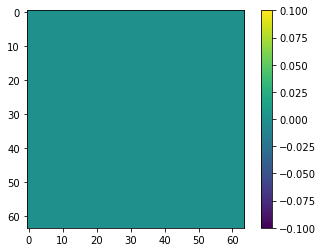

In [34]:
# Video of moving a phase screen
fig, ax = plt.subplots()
image = ax.imshow(numpy.zeros((64, 64)))
fig.colorbar(image)

def init():
    image.set_data(numpy.zeros((64, 64)))
    return (image,)

def animate(i):
    phase_screen.add_row()
    wavefront = phase_screen.scrn
    image.set_data(wavefront)
    image.autoscale()
    return (image,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, 
                               blit=True)

In [35]:
HTML(anim.to_html5_video())

Zernike Breakdown of Phase Screen
-------------------------------------------

Another useful thing to do is to check that the screens follow the expected power laws for atmospheric turbulence. To do this we must first calculate the power we expect at each spatial scale and create an array of Zernike modes to compare the phase screen to.

In [36]:
noll = fits.getdata("../noll.fits").diagonal() * (D/r0)**(5./3)
n_zerns = 60
n_scrns = 100
Zs = aotools.zernikeArray(n_zerns, nx_size)

In [9]:
z_coefficients = numpy.zeros((n_scrns, n_zerns))

for n in tqdm(range(n_scrns)):
    phase_screen = infinitephasescreen.PhaseScreenKolmogorov(nx_size, pxl_scale, r0, L0, stencil_length_factor=stencil_length_factor)
    z_coefficients[n] = (phase_screen.scrn * Zs).sum((-1, -2))/(Zs[0].sum())
        
z_variance = z_coefficients.var(0)

100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


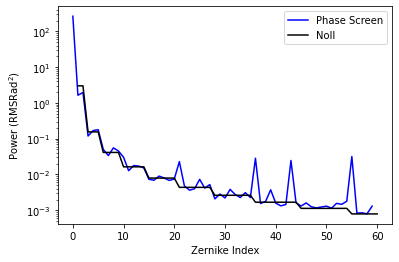

In [10]:
f, a = plt.subplots()
a.plot(z_variance, color="b", label="Phase Screen")
a.plot(range(1, n_zerns+1), noll[:n_zerns] , label="Noll", color="k")
a.set_yscale('log')
a.set_xlabel("Zernike Index")
a.set_ylabel("Power ($\mathrm{RMS Rad}^2$)")
plt.legend()

Note the aliasing effects in some of the Zernike modes and the underestimate of tip/tilt. This illustrates why it is recommended to oversample phase screens compared to pupil size (to mitigate the tip/tilt underestimation)